In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import minimize, shgo
from sklearn.linear_model import LinearRegression

## Obtención de datos

In [2]:
tickers = ['MSFT', 'PG', 'DUK', 'V', 'TSM', 'GLD']
benchmark = 'SPY'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

YF.download() has changed argument auto_adjust default to True


In [3]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,MSFT,PG,DUK,V,TSM,GLD
Date,,,,,,
2021-01-04,210.0020,124.0700,75.7111,211.1414,103.6944,182.3300
2021-01-05,210.2046,124.8622,75.7449,207.9902,104.6877,182.8700
2021-01-06,204.7541,126.1765,76.7239,206.1576,107.3242,179.9000
2021-01-07,210.5808,124.9973,75.8630,207.3115,112.7270,179.4800
2021-01-08,211.8639,124.9432,75.9980,208.9016,110.1834,173.3400



Volumen de los activos


Ticker,MSFT,PG,DUK,V,TSM,GLD
Date,,,,,,
2021-01-04,37130100,8330900,2683700,10318300,11262100,14331400
2021-01-05,23823000,6856400,2547400,6869700,10583600,12718800
2021-01-06,35930700,10578000,2823000,7206200,10609300,18453500
2021-01-07,27694500,7355400,2989500,10967900,13556100,7110200
2021-01-08,22956200,7448500,2752100,6513000,18976800,24399900


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,MSFT,PG,DUK,V,TSM,GLD
Rendimiento Anual,17.67%,9.45%,12.25%,13.41%,18.84%,10.37%
Volatilidad Anual,26.11%,17.05%,18.20%,22.53%,37.31%,14.29%


## Optimización y Evolución de Portafolios

### Funciones de Optimización

In [5]:
def portfolio_return(returns, weights):
    return np.dot(returns, weights)

In [6]:
def opt_sharpe(rt: pd.DataFrame, rf: float) -> np.ndarray:
    """
    Optimiza los pesos de un portafolio para maximizar el Sharpe Ratio.

    Parameters
    ----------
    rt : pd.DataFrame
            Rendimientos de los activos.

    rf : float
            Tasa libre de riesgo.

    Returns
    ----------
    np.ndarray

        Pesos óptimos del portafolio.
    """
    mu = (rt.mean() * 252).values
    sigma = rt.cov().values
    n_assets = len(rt.keys())

    # Función para minimizar (-Sharpe Ratio)
    def neg_sharpe_ratio(w, mu, sigma, rf):
        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)
        return -(port_return - rf) / port_vol

    # Restricciones y límites
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(neg_sharpe_ratio, w0, args=(mu, sigma, rf), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [7]:
def lvrr(price: pd.DataFrame, volume: pd.DataFrame, rf: float, pv: int | float) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el Sharpe Ratio ajustado por liquidez.

    Parameters
    ----------
    price : pd.DataFrame
        Precios de los activos.

    volume : pd.DataFrame
        Volumen de los activos.

    rf : float
        Tasa libre de riesgo.

    pv : int | float
        Valor del portafolio.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    returns = price.pct_change().dropna()
    mu = returns.mean() * 252
    sigma = returns.cov()
    n_assets = len(returns.keys())

    # Volumen promedio de los últimos 3 meses
    adv = volume.iloc[-90:, :].mean()

    def objective(w):
        H = 1 / (adv * price.iloc[-1])
        lr = np.dot(pv, np.dot(w.T, H))

        port_return = np.dot(w.T, mu)
        port_vol = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)

        return -(port_return - rf) / (port_vol * lr)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [8]:
def semivariance(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr

    n_assets = len(rt.keys())

    def objective(w, S):
        return w.T @ S @ w

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets

    result = shgo(objective, bounds, args=(S,), constraints=constraints)
    return result.x

In [9]:
def semivariance_montecarlo(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos minimizando la semivarianza.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    corr = rt.corr()
    S = np.outer(downside, downside) * corr

    weights = np.random.dirichlet(np.ones(len(rt.keys())), size=100000)
    semivariances = np.array([w.T @ S @ w for w in weights])
    return weights[semivariances.argmin()]

In [10]:
def omega(rt: pd.DataFrame, rt_benchmark: pd.DataFrame) -> np.ndarray:
    """
    Optimiza la asignación de activos maximizando el ratio Omega.

    Parameters
    ----------
    rt : pd.DataFrame
        Rendimientos de los activos.

    rt_benchmark : pd.DataFrame
        Rendimientos del benchmark.

    Returns
    ----------
    np.ndarray
    
        Pesos óptimos del portafolio.
    """
    diff = rt - rt_benchmark.values
    downside = diff.where(diff < 0, 0).std()
    upside = diff.where(diff > 0, 0).std()

    omega = upside / downside
    n_assets = len(omega)

    def objective(w, omega):
        return -np.dot(w.T, omega)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1),) * n_assets
    w0 = np.ones(n_assets) / n_assets

    result = minimize(objective, w0, args=(omega,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

## Backtest Estático

In [11]:
pd.reset_option('display.float_format')

rf = 0.05
pv = 1_000_000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_train = benchmark_data.loc[start_date:end_date]
benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_train = benchmark_train.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Máximo Ratio de Sharpe

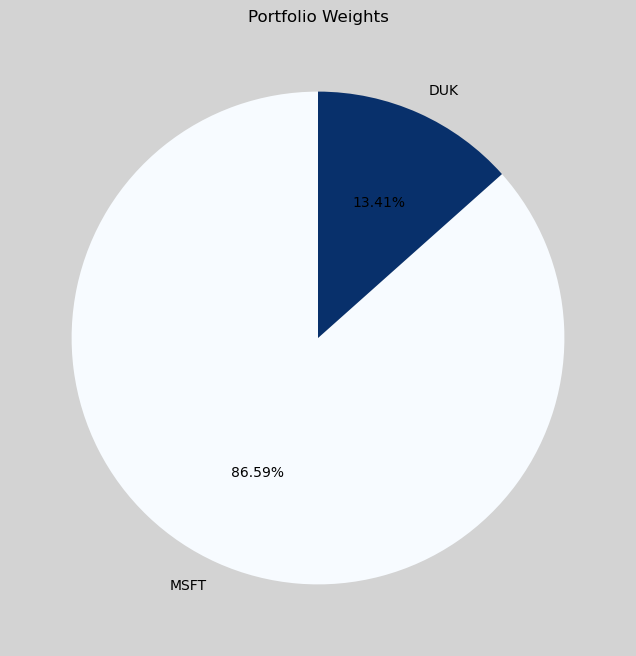

In [12]:
w_sharpe = opt_sharpe(rt_train, rf)
vt.plot_weights(tickers, w_sharpe)

### Liquidity Variance Return Ratio (LVRR)

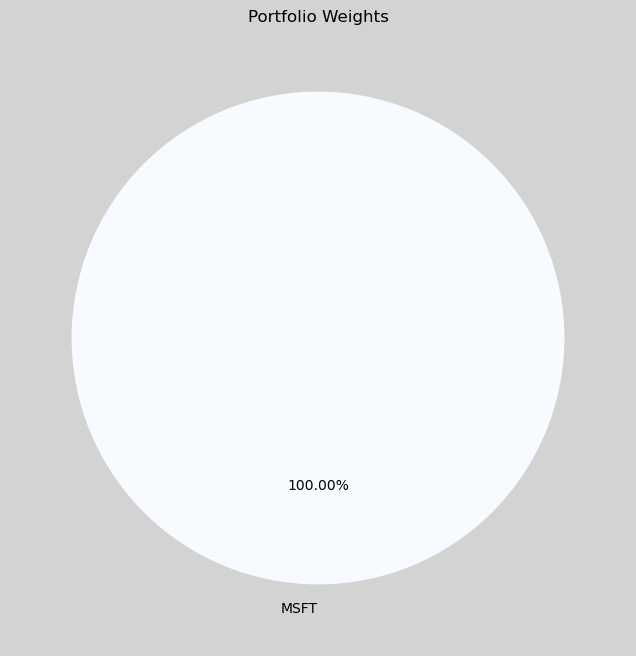

In [13]:
w_lvrr = lvrr(price_train, volume_train, rf, pv)
vt.plot_weights(tickers, w_lvrr)

### Target Semivariance

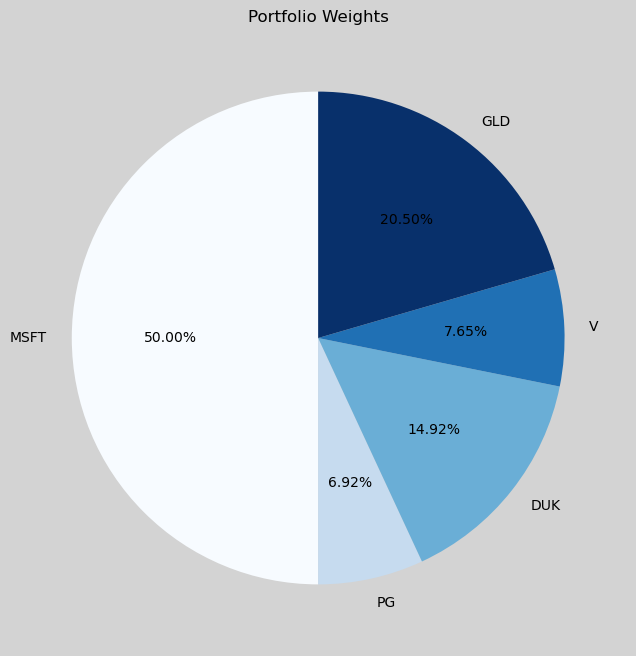

In [14]:
w_semivariance = semivariance(rt_train, rt_benchmark_train)
vt.plot_weights(tickers, w_semivariance)

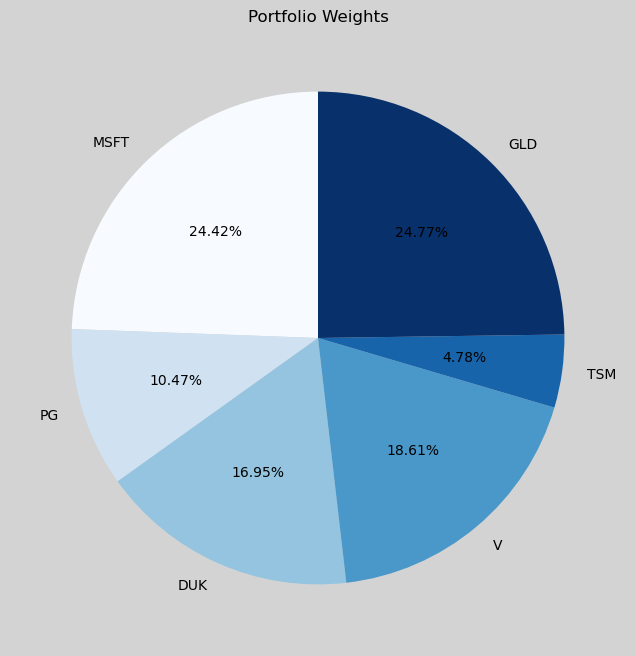

In [15]:
w_semivariance = semivariance_montecarlo(rt_train, rt_benchmark_train)
vt.plot_weights(tickers, w_semivariance)

### Omega

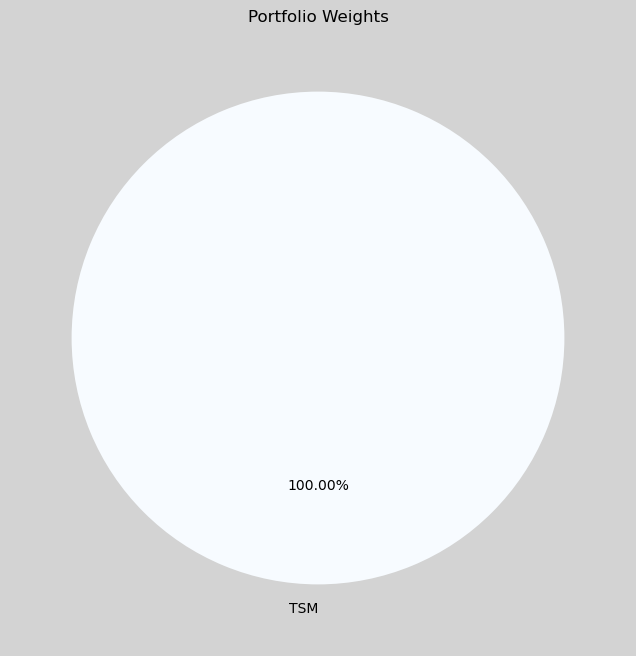

In [16]:
w_omega = omega(rt_train, rt_benchmark_train)
vt.plot_weights(tickers, w_omega)

### Gráfica

In [17]:
strats = [w_sharpe, w_lvrr, w_semivariance, w_omega]
strats_returns = [portfolio_return(rt_test, w) for w in strats]

# Calcular los retornos acumulados y el dinero acumulado
cumulative_returns = [(1 + r).cumprod() for r in strats_returns]
cumulative_money = [pv * cr for cr in cumulative_returns]

# Crear DataFrame para rendimientos y dinero acumulado
cumulative_returns_df = pd.DataFrame(cumulative_returns, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T
cumulative_money_df = pd.DataFrame(cumulative_money, index=['Sharpe', 'LVRR', 'Semivariance', 'Omega']).T

# Comparar con el benchmark
cumulative_benchmark_returns = (1 + rt_benchmark_test).cumprod().squeeze()
cumulative_returns_df['Benchmark'] = cumulative_benchmark_returns.values
cumulative_money_df['Benchmark'] = pv * cumulative_benchmark_returns.values

# DataFrame con los pesos óptmimos
pd.set_option('display.float_format', '{:.2%}'.format)
df_optimal = pd.DataFrame({
    'Ticker': tickers,
    'Sharpe': w_sharpe,
    'LVRR': w_lvrr,
    'Semivariance': w_semivariance,
    'Omega': w_omega
})
df_optimal.set_index('Ticker', inplace=True)

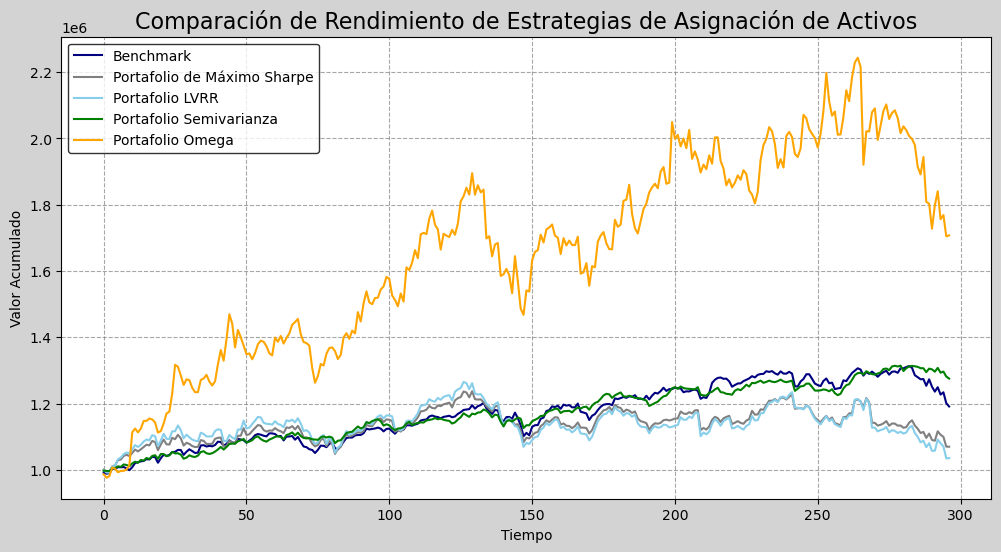

In [18]:
plt.figure(figsize=(12, 6))

plt.plot(cumulative_money_df['Benchmark'], label='Benchmark', c = 'navy')
plt.plot(cumulative_money_df['Sharpe'], label='Portafolio de Máximo Sharpe', c = 'gray')
plt.plot(cumulative_money_df['LVRR'], label='Portafolio LVRR', c = 'skyblue')
plt.plot(cumulative_money_df['Semivariance'], label='Portafolio Semivarianza', c = 'green')
plt.plot(cumulative_money_df['Omega'], label='Portafolio Omega', c = 'orange')

plt.title('Comparación de Rendimiento de Estrategias de Asignación de Activos', fontsize=16)
plt.xlabel('Tiempo')
plt.ylabel('Valor Acumulado')

plt.legend(frameon=True, facecolor='white', edgecolor='black', loc='upper left')
plt.grid(True, linestyle='--', color='gray', alpha=0.7);

In [19]:
print(f'Pesos óptmio de las estrategias')
display(df_optimal.T)
print()

pd.reset_option('display.float_format')
print(f'Evolución de los rendimientos')
display(cumulative_returns_df)

print()

print(f'Evolución del valor del portafolio')
display(cumulative_money_df)

for i in cumulative_money_df.columns:
    print(f'El valor final del portafolio {i} es de {cumulative_money_df[i].iloc[-1]:,.2f}')

Pesos óptmio de las estrategias


Ticker,MSFT,PG,DUK,V,TSM,GLD
Sharpe,86.59%,0.00%,13.41%,0.00%,0.00%,0.00%
LVRR,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%
Semivariance,24.42%,10.47%,16.95%,18.61%,4.78%,24.77%
Omega,0.00%,0.00%,0.00%,0.00%,100.00%,0.00%



Evolución de los rendimientos


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,1.000700,0.999272,0.997524,0.986605,0.991833
1,0.994087,0.992100,0.996776,0.976362,0.988638
2,0.993710,0.991587,0.996201,0.981089,0.989993
3,1.011097,1.010300,1.004510,1.006993,1.004126
4,1.013258,1.013266,1.005625,1.003546,1.002602
...,...,...,...,...,...
292,1.116466,1.091565,1.307733,1.840724,1.249421
293,1.106004,1.080324,1.293346,1.756519,1.227243
294,1.099820,1.070579,1.296541,1.769005,1.234121
295,1.070206,1.034785,1.281752,1.704578,1.201250



Evolución del valor del portafolio


,Sharpe,LVRR,Semivariance,Omega,Benchmark
0,1.000700e+06,9.992720e+05,9.975237e+05,9.866048e+05,9.918333e+05
1,9.940868e+05,9.920997e+05,9.967765e+05,9.763616e+05,9.886384e+05
2,9.937101e+05,9.915874e+05,9.962006e+05,9.810893e+05,9.899926e+05
3,1.011097e+06,1.010300e+06,1.004510e+06,1.006993e+06,1.004126e+06
4,1.013258e+06,1.013266e+06,1.005625e+06,1.003546e+06,1.002602e+06
...,...,...,...,...,...
292,1.116466e+06,1.091565e+06,1.307733e+06,1.840724e+06,1.249421e+06
293,1.106004e+06,1.080324e+06,1.293346e+06,1.756519e+06,1.227243e+06
294,1.099820e+06,1.070579e+06,1.296541e+06,1.769005e+06,1.234121e+06
295,1.070206e+06,1.034785e+06,1.281752e+06,1.704578e+06,1.201250e+06


El valor final del portafolio Sharpe es de 1,069,943.46
El valor final del portafolio LVRR es de 1,035,574.54
El valor final del portafolio Semivariance es de 1,275,449.76
El valor final del portafolio Omega es de 1,707,774.14
El valor final del portafolio Benchmark es de 1,191,263.97


### Métricas de desempeño

In [20]:
X = rt_benchmark_test['SPY'].values.reshape(-1, 1)
y = [strats_returns[i] for i in range(len(strats_returns))]
betas = np.array([LinearRegression().fit(X, i).coef_[0] for i in y])

# Cálculo de rendimiento anualizado, volatilidad y Sharpe
port_ret = np.mean(strats_returns, axis=1) * 252
port_vol = np.std(strats_returns, axis=1) * np.sqrt(252)
sharpe = (port_ret - rf) / port_vol

# Cálculo de alpha
alpha = port_ret - (rf + betas * (((rt_benchmark_test.mean()).iloc[0] * 252)-rf))

# Cálculo de el ratio Sortino
down_risk = [np.minimum(i, 0).std() * np.sqrt(252) for i in strats_returns]
sortino = (port_ret - rf) / down_risk

summary = pd.DataFrame({
    'Rendimiento Anual': port_ret,
    'Volatilidad Anual': port_vol,
    'Sharpe Ratio': sharpe,
    'Beta': betas,
    'Alpha': alpha,
    'Sortino Ratio': sortino
})
summary.set_index(pd.Index(['Sharpe', 'LVRR', 'Semivariance', 'Omega']), inplace=True)
summary

,Rendimiento Anual,Volatilidad Anual,Sharpe Ratio,Beta,Alpha,Sortino Ratio
Sharpe,0.073734,0.180336,0.131612,0.998175,-0.083215,0.197845
LVRR,0.052167,0.211364,0.010253,1.157054,-0.121805,0.015434
Semivariance,0.211214,0.096772,1.665915,0.544476,0.102876,2.687334
Omega,0.546217,0.427811,1.159897,1.850492,0.297946,2.010819


In [21]:
total_return = [cumulative_returns[i][-1] - 1 for i in range(len(cumulative_returns))]
period_years = len(rt_test) / 252
anualized_returns = (np.ones(len(total_return)) + total_return) ** (1 / period_years) - 1
anualized_returns

array([0.05903965, 0.0301042 , 0.22928833, 0.57475756])

In [22]:
vt.var_weights(price_test, w_sharpe, 99), vt.cvar_weights(price_test, w_sharpe, 99)

(0.03184146124387636, 0.04587099775320055)

In [23]:
vt.var_weights(price_test, w_lvrr, 99), vt.cvar_weights(price_test, w_lvrr, 99)

(0.035923086528728776, 0.0532992133750663)

In [24]:
vt.var_weights(price_test, w_semivariance, 99), vt.cvar_weights(price_test, w_semivariance, 99)

(0.01677483960407532, 0.022377762676757243)

In [25]:
vt.var_weights(price_test, w_omega, 99), vt.cvar_weights(price_test, w_omega, 99)

(0.06545747272768168, 0.09418602240195233)

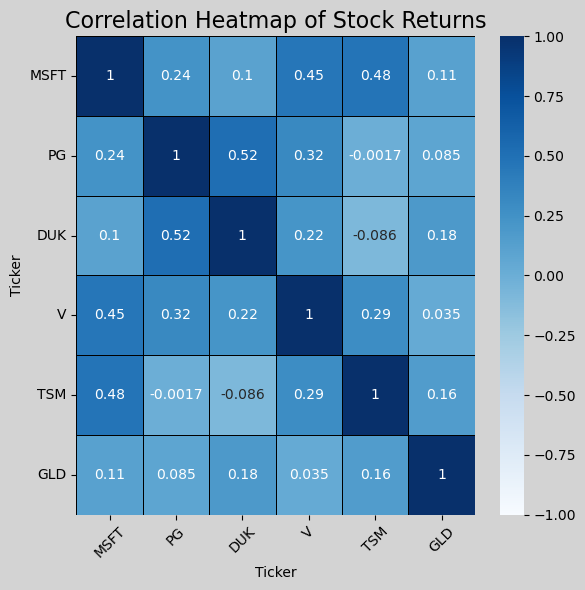

In [26]:
corr = rt.corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corr, 
            annot=True, 
            cmap='Blues', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5, 
            linecolor='black')

plt.title('Correlation Heatmap of Stock Returns', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Luis Márquez, Luis Jimenez and Diego Lozoya
</footer>